In [1]:
!pip install tensorflow
!pip install keras

In [2]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import random
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
import string
import numpy as np
import urllib.request

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Data Preparation

In [3]:
data_url = "https://storage.cloud.google.com/dataset_nutrisee"
data_file_name = "dataset.zip"

Hyper parameters

In [4]:
# Define root directory
root_dir = '/tmp/data'

# Define paths
SOURCE_DIR = "/tmp/dataset/"
TRAINING_DIR = "/tmp/data/training/"
VALIDATION_DIR = "/tmp/data/validation/"

# Define proportion of images used for training
split_size = .8

# Define input shape details
input_height = 224
input_width = 224
num_channels = 3

## Import data from Google Drive

### Import from Downloadable Drive

In [ ]:
# import online

### Import from Local Google Drive

In [5]:
# read csv data file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = "/content/drive/MyDrive/Colab Notebooks/CNN-Capstone-Dataset/dataset.zip"
zip_ref   = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/tmp/dataset')
zip_ref.close()

In [7]:
# show all exported label
print(os.listdir('/tmp/dataset'))

['kotak_jus_jerukmaduless_nutrisari', 'cup_mie_ayambawang_popmie', 'cup_mie_ayam_popmie', 'plastik_mie_goreng_sedaap', 'plastik_mie_ayampanggangjumbo_indomie', 'plastik_mie_ayambawang_sedaap', 'botol_teh_ori_tehgelas', 'zipper_kacang_honeyreasted_mrp', 'botol_yogurt_mixedfruit_cimory', 'kotak_jus_jambu_abc', 'botol_kopi_aren_kopken', 'botol_teh_less_sosro', 'botol_teh_less_tehpucuk', 'plastik_mie_soto_sedaap', 'kaca_nrg_ori_kratingdeng', 'plastik_coklat_dark_silverqueen', 'kotak_jus_apel_abc', 'kotak_susu_fullcream_ultramilk', 'botol_elektrolit_ori_pocari', 'botol_kopi_cappuccino_golda', 'plastik_biskuit_classic_goodtime', 'kaleng_soda_sodawater_polaris', 'kotak_susu_straberry_ultramilk', 'plastik_ringan_keju_twistko', 'plastik_mie_ayambawang_indomie', 'plastik_mie_sotomie_indomie', 'plastik_mie_sotospesial_indomie', 'kaleng_soda_limeapel_greensands', 'cup_mie_goreng_sedaap', 'kaleng_soda_ori_cocacola', 'botol_soda_zerosugar_cocacola', 'botol_soda_strawberry_fanta', 'kaleng_soda_strawb

In [ ]:
shutil.rmtree('/tmp')

## Directory Creation

In [8]:
# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path, classes):
    train_dir = os.path.join(root_path, 'training')
    val_dir = os.path.join(root_path, 'validation')

    # Make directories for each class in training and validation sets
    for class_name in classes:
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)

        os.makedirs(train_class_dir)
        os.makedirs(val_class_dir)

try:
    classes = os.listdir('/tmp/dataset')
    create_train_val_dirs(root_path=root_dir, classes=classes)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [9]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/data/validation
/tmp/data/training
/tmp/data/validation/kotak_jus_jerukmaduless_nutrisari
/tmp/data/validation/cup_mie_ayambawang_popmie
/tmp/data/validation/cup_mie_ayam_popmie
/tmp/data/validation/plastik_mie_goreng_sedaap
/tmp/data/validation/plastik_mie_ayampanggangjumbo_indomie
/tmp/data/validation/plastik_mie_ayambawang_sedaap
/tmp/data/validation/botol_teh_ori_tehgelas
/tmp/data/validation/zipper_kacang_honeyreasted_mrp
/tmp/data/validation/botol_yogurt_mixedfruit_cimory
/tmp/data/validation/kotak_jus_jambu_abc
/tmp/data/validation/botol_kopi_aren_kopken
/tmp/data/validation/botol_teh_less_sosro
/tmp/data/validation/botol_teh_less_tehpucuk
/tmp/data/validation/plastik_mie_soto_sedaap
/tmp/data/validation/kaca_nrg_ori_kratingdeng
/tmp/data/validation/plastik_coklat_dark_silverqueen
/tmp/data/validation/kotak_jus_apel_abc
/tmp/data/validation/kotak_susu_fullcream_ultramilk
/tmp/data/validation/botol_elektrolit_ori_pocari
/tmp/data/validation/botol_kopi_cappuccino_golda
/tmp/d

## Data Splitting

In [10]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  # List all files in the source directory
  files = os.listdir(SOURCE_DIR)

  # Print messages about zero-length images
  for file in files:
    if os.path.getsize(os.path.join(SOURCE_DIR, file)) == 0:
      print(f"{file} is zero length, so ignoring.")

  # Remove zero-sized images
  files = [file for file in files if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0]

  # Calculate the split size
  split_count = len(files) - int(len(files) * SPLIT_SIZE)
  split_index = len(files)//split_count

  # Split the files into training and validation sets
  training_files = []
  validation_files = []

  for i in range(len(files)):
    if (i%split_index) == 0:
      validation_files.append(files[i])
    else:
      training_files.append(files[i])

  # training_files = files[split_count:]
  # validation_files = files[:split_count]

  # Copy training files to the training directory
  for file in training_files:
    source_file = os.path.join(SOURCE_DIR, file)
    destination_file = os.path.join(TRAINING_DIR, file)
    shutil.copyfile(source_file, destination_file)

  # Copy validation files to the validation directory
  for file in validation_files:
    source_file = os.path.join(SOURCE_DIR, file)
    destination_file = os.path.join(VALIDATION_DIR, file)
    shutil.copyfile(source_file, destination_file)

In [11]:
# Make directories for each class in training and validation sets
classes_native = os.listdir(SOURCE_DIR)

for class_name in classes_native:
    TRAINING_CLASS_DIR = os.path.join(TRAINING_DIR, class_name)
    VALIDATION_CLASS_DIR = os.path.join(VALIDATION_DIR, class_name)

    # Empty directories in case you run this cell multiple times
    if len(os.listdir(TRAINING_CLASS_DIR)) > 0:
      for file in os.scandir(TRAINING_CLASS_DIR):
        os.remove(file.path)
    if len(os.listdir(VALIDATION_CLASS_DIR)) > 0:
      for file in os.scandir(VALIDATION_CLASS_DIR):
        os.remove(file.path)

# Run the function
# NOTE: Messages about zero length images should be printed out
for i in range(len(classes_native)):
    TRAINING_CLASS_DIR = os.path.join(TRAINING_DIR, classes[i])
    VALIDATION_CLASS_DIR = os.path.join(VALIDATION_DIR, classes[i])

    SOURCE_CLASS_DIR = os.path.join(SOURCE_DIR, classes_native[i])
    split_data(SOURCE_CLASS_DIR,
               TRAINING_CLASS_DIR,
               VALIDATION_CLASS_DIR,
               split_size)

In [12]:
# Your function should perform copies rather than moving images so original directories should contain unchanged images
for i in range(len(classes_native)):
    TRAINING_CLASS_DIR = os.path.join(TRAINING_DIR, classes[i])
    VALIDATION_CLASS_DIR = os.path.join(VALIDATION_DIR, classes[i])
    SOURCE_CLASS_DIR = os.path.join(SOURCE_DIR, classes_native[i])

    print(f"Original {classes[i]}'s directory has {len(os.listdir(SOURCE_CLASS_DIR))} images")

    # Training and validation splits. Check that the number of images matches the expected output.
    print(f"There are {len(os.listdir(TRAINING_CLASS_DIR))} images of {classes[i]} for training")
    print(f"There are {len(os.listdir(VALIDATION_CLASS_DIR))} images of {classes[i]} for validation")

    print(f"\n")

Original kotak_jus_jerukmaduless_nutrisari's directory has 200 images
There are 160 images of kotak_jus_jerukmaduless_nutrisari for training
There are 40 images of kotak_jus_jerukmaduless_nutrisari for validation


Original cup_mie_ayambawang_popmie's directory has 200 images
There are 160 images of cup_mie_ayambawang_popmie for training
There are 40 images of cup_mie_ayambawang_popmie for validation


Original cup_mie_ayam_popmie's directory has 200 images
There are 160 images of cup_mie_ayam_popmie for training
There are 40 images of cup_mie_ayam_popmie for validation


Original plastik_mie_goreng_sedaap's directory has 200 images
There are 160 images of plastik_mie_goreng_sedaap for training
There are 40 images of plastik_mie_goreng_sedaap for validation


Original plastik_mie_ayampanggangjumbo_indomie's directory has 200 images
There are 160 images of plastik_mie_ayampanggangjumbo_indomie for training
There are 40 images of plastik_mie_ayampanggangjumbo_indomie for validation


Ori

## Data Augmentation Handling

### with Image Augmentation

In [13]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Training datagen
  train_datagen = ImageDataGenerator(rescale=(1./255),
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.3,
                                     brightness_range=[0.05, 0.3],
                                     fill_mode='nearest')

  # Training generator
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=50,
      class_mode='sparse',
      target_size=(input_height, input_width))

  # ==================================================

  # Validation datagen
  validation_datagen = ImageDataGenerator(rescale=(1./255))

  # Validation generator
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=50,
      class_mode='sparse',
      target_size=(input_height, input_width))

  return train_generator, validation_generator

### no Image Augmentation

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Training datagen
  train_datagen = ImageDataGenerator(rescale=(1./255))

  # Training generator
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=20,
      class_mode='sparse',
      target_size=(input_height, input_width))

  # ==================================================

  # Validation datagen
  validation_datagen = ImageDataGenerator(rescale=(1./255))

  # Validation generator
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=20,
      class_mode='sparse',
      target_size=(input_height, input_width))

  return train_generator, validation_generator

### rest of the code...

In [14]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 8640 images belonging to 54 classes.
Found 2160 images belonging to 54 classes.


In [15]:
x_batch_train, y_batch_train = next(train_generator)
print(x_batch_train.shape)  # Should be (batch_size, height, width, channels)
print(y_batch_train.shape)  # Should be (batch_size, num_classes)

(50, 224, 224, 3)
(50,)


In [16]:
x_batch_val, y_batch_val = next(validation_generator)
print(x_batch_val.shape)  # Should be (batch_size, height, width, channels)
print(y_batch_val.shape)  # Should be (batch_size, num_classes)

(50, 224, 224, 3)
(50,)


In [17]:
# Check the class indices to see the order of the labels
print("Class indices:", train_generator.class_indices)
print("Classes:", train_generator.classes)

# Similarly for validation generator
print("Validation Class indices:", validation_generator.class_indices)
print("Validation Classes:", validation_generator.classes)

Class indices: {'botol_elektrolit_ori_pocari': 0, 'botol_kopi_aren_kopken': 1, 'botol_kopi_cappuccino_golda': 2, 'botol_kopi_susu_abc': 3, 'botol_soda_jeruk_fanta': 4, 'botol_soda_ori_cocacola': 5, 'botol_soda_ori_tebs': 6, 'botol_soda_strawberry_fanta': 7, 'botol_soda_zerosugar_cocacola': 8, 'botol_teh_apel_frestea': 9, 'botol_teh_blackcurrant_fruittea': 10, 'botol_teh_less_sosro': 11, 'botol_teh_less_tehpucuk': 12, 'botol_teh_ori_sosro': 13, 'botol_teh_ori_tehgelas': 14, 'botol_yogurt_mixedfruit_cimory': 15, 'botol_yogurt_ori_cimory': 16, 'cup_mie_ayam_popmie': 17, 'cup_mie_ayambawang_popmie': 18, 'cup_mie_goreng_sedaap': 19, 'cup_mie_kariayam_popmie': 20, 'cup_mie_sotoayam_popmie': 21, 'kaca_nrg_ori_kratingdeng': 22, 'kaleng_soda_limeapel_greensands': 23, 'kaleng_soda_ori_cocacola': 24, 'kaleng_soda_ori_sprite': 25, 'kaleng_soda_sodawater_polaris': 26, 'kaleng_soda_strawberry_fanta': 27, 'kaleng_susu_ori_beruang': 28, 'kotak_jus_apel_abc': 29, 'kotak_jus_jambu_abc': 30, 'kotak_jus_j

# Data Processing

## Model Creation

In [23]:
def convLayers(inputs):
    x = layers.Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(inputs)

    x = layers.Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    x = tf.keras.layers.MaxPooling2D()(x)

    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    x = tf.keras.layers.MaxPooling2D()(x)

    #x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    #x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    #x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    #x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    #x = tf.keras.layers.MaxPooling2D()(x)

    return x

In [24]:
def basicModel(inputs, num_classes):
    x_a = convLayers(inputs)
    x_a = layers.Dropout(0.2)(x_a)
    x_a = layers.Flatten()(x_a)
    x_a = layers.BatchNormalization()(x_a)

    x_b = convLayers(tf.image.rgb_to_grayscale(inputs))
    x_b = layers.Dropout(0.2)(x_b)
    x_b = layers.Flatten()(x_b)
    x_b = layers.BatchNormalization()(x_b)

    x = layers.Concatenate()([x_a, x_b])
    x = layers.Activation('relu')(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inputs, outputs=x)

#### Scratch (Mobile-Net and VGG)

In [ ]:
def vggBlock(inputs, filters, kernel_size, repetitions, pool_size=2, strides=2):
  x = inputs
  for i in range(repetitions):
    x = tf.keras.layers.Conv2D(filters,
                               kernel_size,
                               activation='relu',
                               padding='same')(x)

  x = tf.keras.layers.MaxPooling2D(pool_size=pool_size,
                                   strides=strides,
                                   padding='same')(x)

  x = tf.keras.layers.BatchNormalization()(x)

  return x

In [ ]:
def mobileNetBlock(inputs, filters, strides):
  # x = tf.keras.layers.DepthwiseConv2D(kernel_size = 3,
  #                                     strides = strides,
  #                                     padding = 'same')(inputs)
  # x = tf.keras.layers.BatchNormalization()(x)
  # x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Conv2D(filters = filters,
                            kernel_size = 3,
                            strides = 1)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  return x


In [ ]:
def baseLayers(inputs):
  x = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, strides = 2, padding = 'same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU(max_value=6.0)(x)

  x = mobileNetBlock(inputs, 16, 1)
  x = mobileNetBlock(x, 32, 2)
  x = x = mobileNetBlock(x, 32, 1)

  return x

In [ ]:
def mobileNet(inputs, num_classes):
  x = baseLayers(tf.image.rgb_to_grayscale(inputs))

  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  classification = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  return Model(inputs=inputs, outputs=classification)

#### Transfer Learning (Mobile-Net)

In [ ]:
# Load the pre-trained MobileNet model with the top layers excluded
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(input_height, input_width, num_channels),  # Specify input shape
    alpha=1.0,
    include_top=False,  # Exclude the top classification layer
    weights="imagenet",  # Load weights pre-trained on ImageNet
    input_tensor=None,
    pooling=None,  # Use the final conv layer as output
)

# Freeze the base model
base_model.trainable = False

# Create the model
myCNN = tf.keras.Sequential()

# Add the base model
myCNN.add(base_model)

# Add global average pooling layer
myCNN.add(tf.keras.layers.GlobalAveragePooling2D())

# Add a dropout layer for regularization
myCNN.add(tf.keras.layers.Dropout(0.5))

# Add a dense layer with 8 units for the 8 classes
myCNN.add(tf.keras.layers.Dense(8, activation='softmax'))


## Model Creation (sayang dibuang)

In [ ]:
class Conv2DLayers(tf.keras.Model):
  def __init__(self, filters, kernel_size, repetitions):
    super(Conv2DLayers, self).__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.repetitions = repetitions

    self.sequential = tf.keras.Sequential()
    for i in range(repetitions):
      self.sequential.add(
          tf.keras.layers.Conv2D(self.filters, self.kernel_size, padding='same', activation='relu'))

  def call(self, inputs):
    return self.sequential(inputs)

In [ ]:
class Block(tf.keras.Model):
  def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
    super(Block, self).__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.repetitions = repetitions

    # define a stack of conv2D layers based on repetition
    # self.conv2D_layers = Conv2DLayers(self.filters, self.kernel_size, self.repetitions)
    for i in range(repetitions):
      # Define a Conv2D layer, specifying filters, kernel_size, activation and padding.
      vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(self.filters,
                                                          self.kernel_size,
                                                          activation='relu',
                                                          padding='same')


    self.max_pool = tf.keras.layers.MaxPool2D(pool_size=pool_size,
                                              strides=strides,
                                              padding='same')

  def call(self, inputs):
    # access the conv2D
    # x = self.conv2D_layers(inputs)

    # access the class's conv2D_0 layer
    conv2D_0 = vars(self)['conv2D_0']

    # Connect the conv2D_0 layer to inputs
    x = conv2D_0(inputs)

    # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
    for i in range(1, self.repetitions):
      # access conv2D_i by formatting the integer `i`. (hint: check how these were saved using `vars()` earlier)
      conv2D_i = vars(self)[f'conv2D_{i}']

      # Use the conv2D_i and connect it to the previous layer
      x = conv2D_i(x)

    x = self.max_pool(x)

    return x

In [ ]:
# VGG based CNN

class RGBModel(tf.keras.Model):
  def __init__(self, num_classes):
    super(RGBModel, self).__init__()

    # Creating blocks of VGG with the following
    # (filters, kernel_size, repetitions) configurations
    self.block_a = Block(64, 3, 2)
    self.block_b = Block(128, 3, 2)
    self.block_c = Block(256, 3, 3)
    self.block_d = Block(512, 3, 3)
    self.block_e = Block(512, 3, 3)

    # Define a Flatten layer
    self.flatten = tf.keras.layers.Flatten()
    self.act = tf.keras.layers.Activation('relu')

    # Create a Dense layer
    self.dense_0 = tf.keras.layers.Dense(256, activation='relu')
    self.dense_1 = tf.keras.layers.Dense(512, activation='relu')

    # Finally add the softmax classifier using a Dense layer
    self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

  def call(self, inputs):
    x = self.block_a(inputs)
    x = self.block_b(x)
    x = self.block_c(x)
    x = self.block_d(x)
    x = self.block_e(x)

    x = self.flatten(x)
    x = self.act(x)

    x = self.dense_0(x)
    x = self.dense_1(x)

    return self.classifier(x)

In [ ]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size, l2_reg=0.07):
        super(IdentityBlock, self).__init__()

        self.conv2D_0 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same',
                                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.bn_0 = tf.keras.layers.BatchNormalization()

        self.conv2D_1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same',
                                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.bn_1 = tf.keras.layers.BatchNormalization()

        self.conv2D_2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same',
                                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()

    def call(self, inputs):
        x = self.conv2D_0(inputs)
        x = self.bn_0(x)
        x = self.act(x)

        x = self.conv2D_1(x)
        x = self.bn_1(x)
        x = self.act(x)

        input_conv = self.conv2D_2(inputs)
        x = self.add([x, input_conv])
        x = self.act(x)

        return x

class BWModel(tf.keras.Model):
    def __init__(self, num_classes, l2_reg=0.07):
        super(BWModel, self).__init__()
        self.conv2D = tf.keras.layers.Conv2D(64, 7, padding='same',
                                             kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        self.id_block_1 = IdentityBlock(64, 3, l2_reg)
        self.id_block_2 = IdentityBlock(64, 3, l2_reg)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.drop = tf.keras.layers.Dropout(0.8)

        self.dense_0 = tf.keras.layers.Dense(256, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv2D(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # Insert the identity blocks in the middle of the network
        x = self.id_block_1(x)
        x = self.drop(x)
        x = self.id_block_2(x)
        x = self.drop(x)

        x = self.global_pool(x)
        x = self.flatten(x)

        x = self.dense_0(x)

        return self.classifier(x)

In [ ]:
# Combination between VGG and ResNet-18

class CNNPalingPerkasa(tf.keras.Model):
  def __init__(self, num_classes):
    super(CNNPalingPerkasa, self).__init__()
    self.rgbModel_1 = RGBModel(num_classes)
    # self.rgbModel_2 = RGBModel()
    self.bwModel = BWModel(num_classes)

    self.act = tf.keras.layers.Activation('relu')

    # Create a Dense layer
    self.dense_0 = tf.keras.layers.Dense(te256, activation='relu')
    self.dense_1 = tf.keras.layers.Dense(512, activation='relu')

    # Finally add the softmax classifier using a Dense layer
    self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

  def call(self, inputs):
    # Pass each image data to the respective models
    rgb_1 = self.rgbModel_1(inputs)
    # rgb_2 = self.rgbModel_2(tf.image.rgb_to_grayscale(inputs))
    bw = self.bwModel(tf.image.rgb_to_grayscale(inputs))

    # Combine the outputs and perform further operations
    # x_a = tf.concat([rgb_1, bw], axis=-1)
    # x_a = self.act(x_a)

    x = tf.concat([rgb_1, bw], axis=-1)
    x = self.act(x)
    # x = self.dense_0(rgb_1)
    x = self.dense_1(x)
    x = self.classifier(x)

    return x

## Model Training

In [25]:
input_height = 224
input_width = 224
num_channels = 3
num_classes = 54

In [26]:
# Definisikan input layer
inputs = tf.keras.Input(shape=(input_height, input_width, num_channels))

In [27]:
# Bangun model menggunakan fungsi basicModel
myCNN = basicModel(inputs, num_classes)

In [28]:
myCNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = myCNN.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
173/173 [==============================] - 124s 703ms/step - loss: 3.2702 - accuracy: 0.1516 - val_loss: 2.6073 - val_accuracy: 0.2870
Epoch 2/20
173/173 [==============================] - 119s 685ms/step - loss: 1.7698 - accuracy: 0.4731 - val_loss: 1.0088 - val_accuracy: 0.6847
Epoch 3/20
173/173 [==============================] - 119s 688ms/step - loss: 1.1851 - accuracy: 0.6238 - val_loss: 0.8638 - val_accuracy: 0.7597
Epoch 4/20
173/173 [==============================] - 121s 699ms/step - loss: 0.8276 - accuracy: 0.7237 - val_loss: 0.5314 - val_accuracy: 0.8676
Epoch 5/20
173/173 [==============================] - 122s 706ms/step - loss: 0.6680 - accuracy: 0.7789 - val_loss: 0.7671 - val_accuracy: 0.8542
Epoch 6/20
173/173 [==============================] - 120s 695ms/step - loss: 0.5670 - accuracy: 0.8072 - val_loss: 0.4113 - val_accuracy: 0.9083
Epoch 7/20
173/173 [==============================] - 121s 700ms/step - loss: 0.5189 - accuracy: 0.8273 - val_loss: 0.4563 -

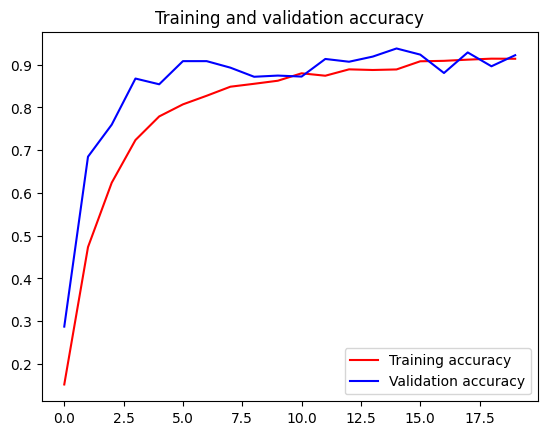

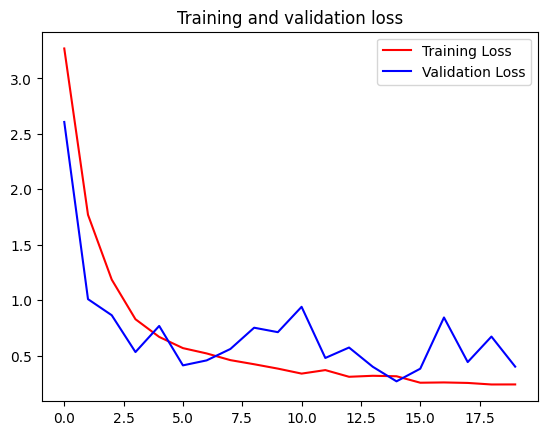

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model Testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load the image
new_image = plt.imread('/content/drive/MyDrive/Colab Notebooks/CNN-Capstone-Dataset/nu.jpg')

# Ensure the image has the correct number of channels (e.g., 3 for RGB)
if new_image.shape[-1] != 3:
    new_image = tf.image.grayscale_to_rgb(new_image)

# Resize the image to the input shape required by your model
input_shape = (input_height, input_width)  # Replace with your model's input shape
new_image = tf.image.resize(new_image, input_shape)

# Normalize the image (if your model was trained on normalized images, e.g., values in range [0, 1])
new_image = new_image / 255.0

# Add a batch dimension
new_image = np.expand_dims(new_image, axis=0)

# Make predictions
predictions = myCNN.predict(new_image)

# Print the predictions
print("Predictions:", predictions)

# Print the predicted label
predicted_label = np.argmax(predictions, axis=1)
print("Predicted label:", predicted_label)

print(list(train_generator.class_indices)[np.argmax(predictions)])

## Model Export

In [30]:
myCNN.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
export_dir = 'saved_model/1'
# myCNN.save(export_dir)
tf.saved_model.save(myCNN, export_dir)

In [ ]:
drink_recog = '/content/Model.h5'

myCNN.save(drink_recog, save_format="h5")

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # TFLite built-in ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops
]
tflite_model = converter.convert()

In [ ]:
import pathlib

tflite_model_file = pathlib.Path('/content/model.tflite')
tflite_model_file.write_bytes(tflite_model)

print(f"TFLite model saved at: {tflite_model_file}")